<a href="https://colab.research.google.com/github/ManuSinghYadav/Image-Clustering/blob/main/Image_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Feature Extraction by VGG16

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

In [13]:
model = VGG16(weights='imagenet', include_top=False)

In [62]:
import os

file_list = os.listdir('/content/Images')
img_name = []
flattened_features = []

for i in file_list:
  if i=='.ipynb_checkpoints':
    continue
  else:
    a = '/content/Images/{}'.format(i)
    img = image.load_img(a, target_size = (224, 224))
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = model.predict(img)
    img_name.append(i)
    flattened_features.append(features.flatten())

1/1 [==============================] - 0s 488ms/step


###Clustering

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

####Calculating WCSS for determining optimal number of clusters.

In [64]:
wcss = []
for i in range(1, 80):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(flattened_features)
    wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

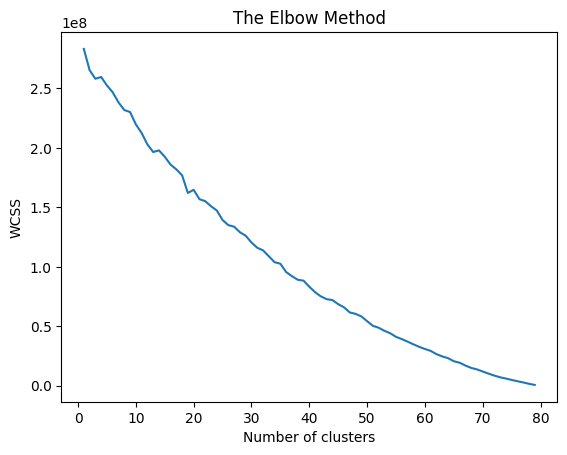

In [65]:
plt.plot(range(1, 80), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

####Training K Means clustering algorithm

In [66]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(flattened_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [67]:
cluster_labels = kmeans.labels_

In [68]:
cluster_labels

array([1, 4, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 8, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 6, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1], dtype=int32)

####Making final table

In [69]:
import pandas as pd

In [70]:
a = pd.DataFrame(img_name)

In [71]:
a['cluster'] = cluster_labels

In [72]:
a

,0,cluster
0,man-gb4440ab53_640.jpg,1
1,mandu-g79128b0db_640.jpg,4
2,women-girl-gf81cdab46_640.jpg,1
3,puppy-ge9d742e37_640.jpg,1
4,beanie-g4c423e47b_640.jpg,1
...,...,...
75,selfie-g46d822e69_640.jpg,1
76,man-g6d33fb453_640.jpg,1
77,octopus-desktop-gab5dc2902_640.jpg,7
78,grandmother-g010adc60b_640.jpg,1


In [73]:
for i in range(10):
  print(i," - ",len(a[a['cluster'] == i]))

0  -  1
1  -  70
2  -  1
3  -  1
4  -  1
5  -  1
6  -  2
7  -  1
8  -  1
9  -  1


In [74]:
a[a['cluster'] == 1]

,0,cluster
0,man-gb4440ab53_640.jpg,1
2,women-girl-gf81cdab46_640.jpg,1
3,puppy-ge9d742e37_640.jpg,1
4,beanie-g4c423e47b_640.jpg,1
5,cat-g0fcd844a4_640.jpg,1
...,...,...
74,girl-g6a909b6e4_640.jpg,1
75,selfie-g46d822e69_640.jpg,1
76,man-g6d33fb453_640.jpg,1
78,grandmother-g010adc60b_640.jpg,1
